# Prevendo o Número de Matrículas das escolas

### Importando as tabelas
Esquemas:
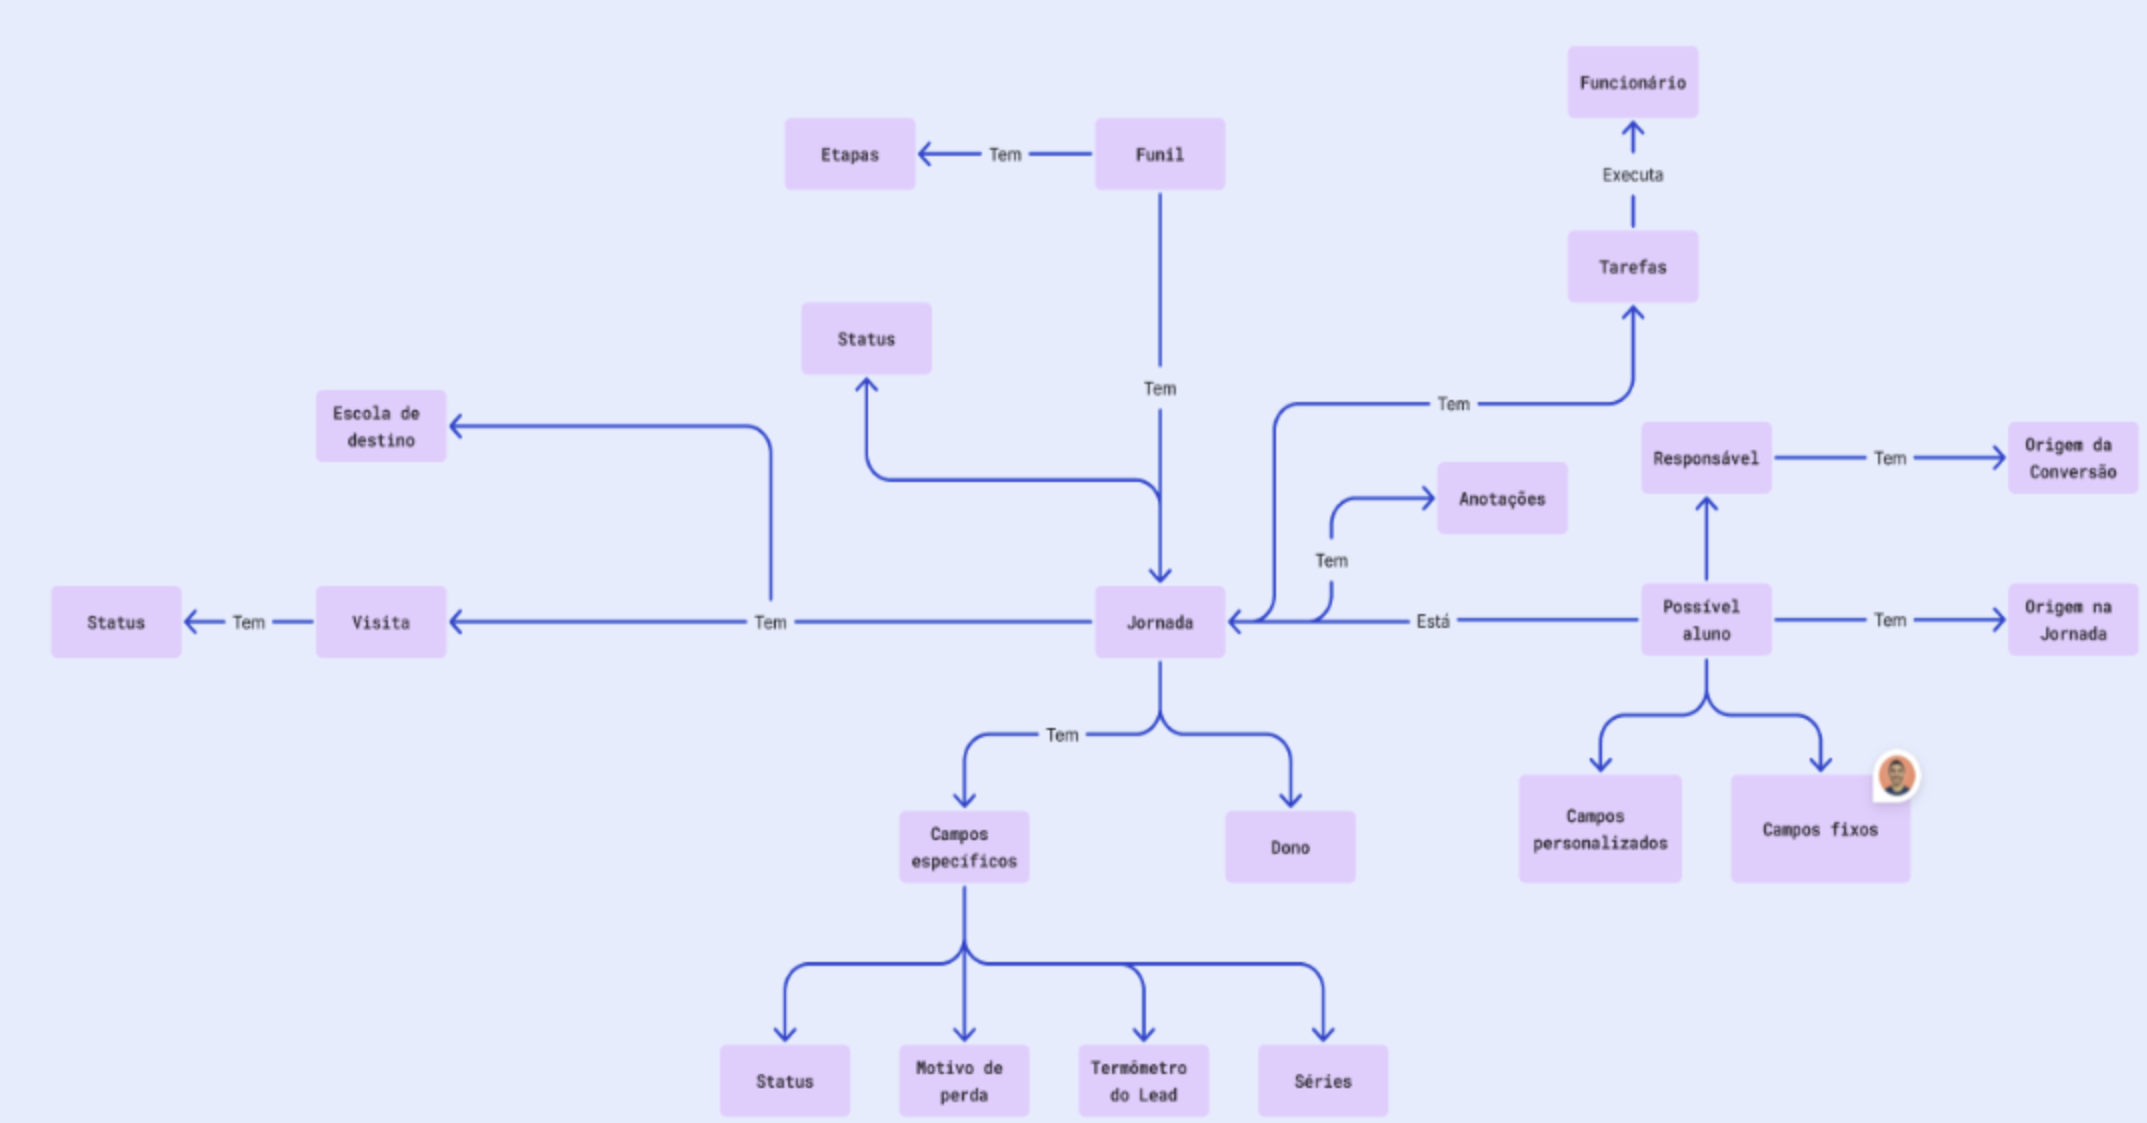


Vamos fazer um modelo de regressão para descobrir o número de matrículas presvistas em cada mês;
Inicialmente vamos fazer um modelo simples e depois tentar aprimorar com séries temporais;

As variáveis que vamos usar são:


Propostas pelo Guru:

- Número de entrada de leads
- Número de visitas
- Número de candidatos Frios e Números de candidatos Quentes
- Mês

Isso aqui são variáveis úteis para um modelo de classificação, não regressão:
- Velocidade em dias da entrada no funil ate o agendamento da visita
- Distâncias das datas (entrada e visita) ate o fim do mes

Mas poderíamos pegar uma média e colocar como variável(é um indicador de atendimento)

Propostas pelo Felipe:
- De algum jeito incorporar o tamanho da escola
- 

### Importando bibliotecas

In [1]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler


In [2]:
from db_connect import connect_to_db

conn = connect_to_db()
if conn:
    cur = conn.cursor()
    
    # Consulta para listar as tabelas existentes no banco
    cur.execute("""
        SELECT table_name 
        FROM information_schema.tables 
        WHERE table_schema = 'public';
    """)
    
    tables = cur.fetchall()

    tables = list(tables)
    tables = sorted(tables) 
    tabelas = []   
    if tables:
        print("Tabelas disponíveis no banco:")
        for table in tables:
            print(table[0])
            tabelas.append(table[0])
    else:
        print("Nenhuma tabela encontrada.")

    cur.close()
    conn.close()

Tabelas disponíveis no banco:
agenda_agendamento
agenda_calendarauthentication
agenda_calendariodisponivel
agenda_campodevolutivavisita
agenda_devolutivavisita
agenda_diadisponivel
agenda_escolhamultipladevolutivavisita
agenda_escolhaunicadevolutivavisita
agenda_horariodisponivel
agenda_valorcampodevolutivavisita
auth_group
auth_group_permissions
auth_permission
authentication_account
authentication_verificationtoken
captacao_botaosite
captacao_botaosite_dono
captacao_botaostatusurlsautorizadas
captacao_campoformulario
captacao_formulario
captacao_formulario_dono
captacao_landingpage
captacao_landingpage_dono
captacao_landingpagestatus
captacao_mensagempadronizada
captacao_metas
captacao_tipomensagempadronizada
crm_aluno
crm_anotacao
crm_campopersonalizado
crm_camposescolhamultipla
crm_camposescolhaunica
crm_comoconheceuescola
crm_escola
crm_escoladestino
crm_etapafunil
crm_funil
crm_historicointeracoes
crm_jornada
crm_jornadaetapa
crm_motivochurn
crm_origemlead
crm_registroconversa
cr

### Funções de Consulta

In [3]:
def verificar_colunas(table):
    conn = connect_to_db()
    if conn:
        cur = conn.cursor()
        query = """
            SELECT column_name, data_type
            FROM information_schema.columns
            WHERE table_name = %s;
        """
        cur.execute(query, (table,))

        columns = cur.fetchall()

        print(f"Colunas na tabela {table}:")
        colunas = []
        for column in columns:
            colunas.append(column[0])

        cur.close()
        conn.close()
        return colunas

In [4]:
def get_dataframe(table, columns = None):
    conn = connect_to_db()
    if conn:
        cur = conn.cursor()

        if columns is None:
            cols_str = '*'
        else:
            cols_str = ', '.join(columns)

        cur.execute(f"SELECT {cols_str} FROM {table};")
        rows = cur.fetchall()

        # obter nomes das colunas automaticamente se columns=None
        if columns is None:
            columns = [desc[0] for desc in cur.description]

        df = pd.DataFrame(rows, columns=columns)

        cur.close()
        conn.close()

        return df

## Estudando os Dados

### Verificando as escolas existentes e removendo as que foram deletadas

In [5]:
escolas = pd.DataFrame(get_dataframe('crm_escola', ['id', 'created_at', 'deleted_at', 'nome']))
escolas.head()

,id,created_at,deleted_at,nome
0,2,2023-09-18 14:44:38+00:00,None,Aldeia
1,3,2023-09-18 14:59:04+00:00,None,Colégio Inovar Veiga de Almeida
2,4,2023-09-18 14:59:24+00:00,None,Colégio Época Inova+
3,5,2023-09-18 15:00:09+00:00,None,Colégio Ativa Idade
4,6,2023-09-19 06:27:14+00:00,None,Escola Vila Lume


In [6]:
escolas['deleted_at'].notna().sum()

np.int64(0)

Não temos dados de escolas deletadas

In [7]:
escolas = escolas.drop(columns = 'deleted_at')
escolas.head()

,id,created_at,nome
0,2,2023-09-18 14:44:38+00:00,Aldeia
1,3,2023-09-18 14:59:04+00:00,Colégio Inovar Veiga de Almeida
2,4,2023-09-18 14:59:24+00:00,Colégio Época Inova+
3,5,2023-09-18 15:00:09+00:00,Colégio Ativa Idade
4,6,2023-09-19 06:27:14+00:00,Escola Vila Lume


Buscando escolas selecionadas para treino

In [8]:
escolas[escolas['nome'].str.lower().str.contains('master')]

,id,created_at,nome
65,72,2024-10-02 20:21:42.891428+00:00,UNICA Master


Id's das escolas que o Guru recomendou

In [9]:
escolas_ref_id = [10, 33, 42, 9, 7]

### Ver as Jornadas - onde tem dados de matrículas

In [10]:
jornada = get_dataframe('crm_jornada')
jornada.head()

,id,created_at,updated_at,date_churn,date_matricula,aluno_id,funil_id,usuario_responsavel_id,status,termometro,motivo_churn_id,turma_id,turno_id,escola_id,principal,etapa_atual_id,etapa_atual_date_in,escola_destino_id,deleted_at
0,47359,2023-09-24 20:14:13.179000+00:00,2024-03-01 11:43:48.704087+00:00,NaT,2024-03-01 11:43:48.692561+00:00,70145,239,64,MATRICULADO,FRIO,NaN,NaN,NaN,9,True,1247,2024-03-01 11:43:48.695006+00:00,NaN,None
1,123691,2024-11-16 11:49:22.941720+00:00,2024-12-10 16:04:14.885341+00:00,2024-12-10 16:04:14.867322+00:00,NaT,186860,480,332,PERDIDO,FRIO,1397.0,2210.0,NaN,71,True,2667,2024-11-22 17:16:01.929783+00:00,NaN,None
2,83706,2024-08-02 20:53:51.741959+00:00,2025-01-14 14:59:57.789240+00:00,2024-08-06 13:23:40.537929+00:00,NaT,121537,365,146,PERDIDO,FRIO,1180.0,1869.0,NaN,36,True,1944,2025-01-14 14:59:57.767568+00:00,NaN,None
3,58386,2023-03-31 11:30:00+00:00,2023-03-31 11:30:00+00:00,NaT,2023-03-31 00:00:00+00:00,84686,287,94,MATRICULADO,FRIO,NaN,1549.0,NaN,25,True,1515,2023-03-31 11:30:00+00:00,NaN,None
4,68257,2024-04-25 00:24:32.478443+00:00,2024-04-25 00:24:32.478443+00:00,2024-01-01 00:00:00+00:00,NaT,104077,311,110,PERDIDO,FRIO,NaN,1597.0,NaN,32,True,1638,2024-04-25 00:24:32.478443+00:00,NaN,None


In [11]:
jornada['status'].value_counts()

status
PERDIDO         51186
EM_ANDAMENTO    25805
MATRICULADO     12998
PAUSADO          1249
Name: count, dtype: int64

Agrupando por data

In [12]:
jornada['updated_at'] = pd.to_datetime(jornada['updated_at']).dt.date
matriculas = jornada.groupby(['updated_at', 'escola_id']).agg(
    total=('escola_id', 'count'),
    quentes=('termometro', lambda x: (x == 'QUENTE').sum()),
    frios=('termometro', lambda x: (x == 'FRIO').sum()),
    matriculas=('status', lambda x: (x == 'MATRICULADO').sum()),
    perdidos=('status', lambda x: (x == 'PERDIDO').sum())
).reset_index()

matriculas

,updated_at,escola_id,total,quentes,frios,matriculas,perdidos
0,2019-02-12,39,1,0,1,0,0
1,2019-05-12,39,4,0,4,0,0
2,2019-06-12,39,1,0,1,0,0
3,2019-10-12,39,1,0,1,0,0
4,2019-11-12,39,1,0,1,1,0
...,...,...,...,...,...,...,...
7879,2025-03-24,95,2,0,2,0,2
7880,2025-03-24,99,114,0,114,0,0
7881,2025-03-24,102,1,0,1,0,0
7882,2025-03-24,103,2,0,2,0,0


Agrupando por mês-ano

In [13]:
jornada['updated_at'] = pd.to_datetime(jornada['updated_at'])

jornada['updated_month'] = jornada['updated_at'].dt.to_period("M")

# Agregação por mês e escola_id
matriculas_mensais = jornada.groupby(['updated_month', 'escola_id']).agg(
    total=('escola_id', 'count'),
    quentes=('termometro', lambda x: (x == 'QUENTE').sum()),
    frios=('termometro', lambda x: (x == 'FRIO').sum()),
    matriculas=('status', lambda x: (x == 'MATRICULADO').sum()),
    perdidos=('status', lambda x: (x == 'PERDIDO').sum())
).reset_index()

# Converter `updated_month` para string para exibição
matriculas_mensais['updated_month'] = matriculas_mensais['updated_month'].astype(str)

# Exibir resultado
matriculas_mensais

,updated_month,escola_id,total,quentes,frios,matriculas,perdidos
0,2019-02,39,1,0,1,0,0
1,2019-05,39,4,0,4,0,0
2,2019-06,39,1,0,1,0,0
3,2019-10,39,1,0,1,0,0
4,2019-11,39,8,0,8,4,0
...,...,...,...,...,...,...,...
786,2025-03,99,126,0,122,0,0
787,2025-03,102,2252,1,2248,337,1255
788,2025-03,103,1600,2,1598,219,793
789,2025-03,104,1153,173,861,214,265


In [14]:
matriculas_mensais['mês'] = pd.to_datetime(matriculas_mensais['updated_month']).dt.month
matriculas_mensais['updated_month'] = pd.to_datetime(matriculas_mensais['updated_month']).dt.strftime('%m-%Y')

matriculas_mensais.head()

,updated_month,escola_id,total,quentes,frios,matriculas,perdidos,mês
0,02-2019,39,1,0,1,0,0,2
1,05-2019,39,4,0,4,0,0,5
2,06-2019,39,1,0,1,0,0,6
3,10-2019,39,1,0,1,0,0,10
4,11-2019,39,8,0,8,4,0,11


<Axes: xlabel='updated_month', ylabel='Count'>

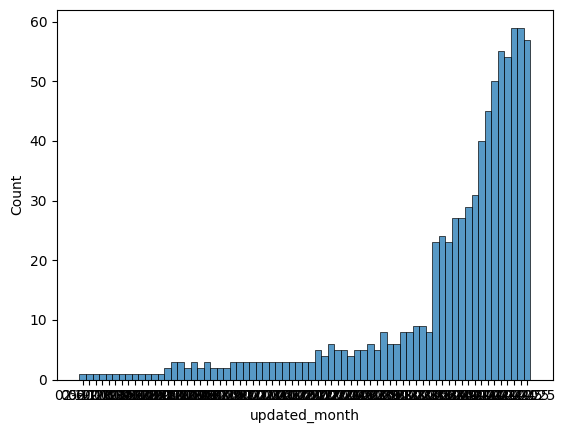

In [15]:
sns.histplot(matriculas_mensais['updated_month'])

### Procurando por outras variáveis, como número de Leads e Visitas

In [16]:
verificar_colunas('agenda_agendamento')

Colunas na tabela agenda_agendamento:


['deleted_at',
 'created_at',
 'updated_at',
 'date_inicio',
 'date_fim',
 'created_by_id',
 'escola_id',
 'jornada_id',
 'usuario_responsavel_id',
 'responsavel_id',
 'id',
 'tipo',
 'motivo_ausente',
 'description',
 'location',
 'status',
 'id_evento',
 'meet_link',
 'calendar_link',
 'summary',
 'outro_motivo']

In [17]:
agendamento = get_dataframe('agenda_agendamento', ['usuario_responsavel_id', 'responsavel_id', 'updated_at', 'date_inicio', 'date_fim', 'escola_id', 'status'])
agendamento.head()

,usuario_responsavel_id,responsavel_id,updated_at,date_inicio,date_fim,escola_id,status
0,205,156515,2024-11-29 16:26:52.920481+00:00,2024-11-28 11:00:00+00:00,2024-11-28 11:30:00+00:00,40,realizado
1,5,67236,2024-03-06 17:15:25.549098+00:00,2024-03-08 18:30:00+00:00,2024-03-08 19:00:00+00:00,2,tentative
2,5,70344,2024-03-06 17:42:58.314038+00:00,2024-03-08 14:00:00+00:00,2024-03-08 15:00:00+00:00,2,tentative
3,5,70349,2024-03-07 17:33:18.366014+00:00,2024-03-08 18:00:00+00:00,2024-03-08 18:30:00+00:00,2,tentative
4,93,70383,2024-03-14 11:38:50.748843+00:00,2024-03-06 15:00:00+00:00,2024-03-06 15:15:00+00:00,20,realizado


In [18]:
agendamento['updated_at'] = pd.to_datetime(agendamento['updated_at'])

agendamento['updated_month'] = agendamento['updated_at'].dt.strftime('%m-%Y')

# Filtrar apenas os status finais (se necessário)
agendamento = agendamento.sort_values(['escola_id', 'updated_at', 'status'])  # Ordenando para pegar o último status
agendamento_final = agendamento.drop_duplicates(subset=['responsavel_id', 'escola_id', 'updated_at'], keep='last')

# Agrupar por mês-ano e escola_id
visitas_mensais = agendamento_final.groupby(['updated_month', 'escola_id']).agg(
    realizadas=('status', lambda x: (x == 'realizado').sum()),
    tentativas=('status', lambda x: (x == 'tentative').sum())
).reset_index()

visitas_mensais

,updated_month,escola_id,realizadas,tentativas
0,01-2025,1,5,0
1,01-2025,2,2,0
2,01-2025,5,22,0
3,01-2025,7,42,2
4,01-2025,9,128,2
...,...,...,...,...
331,12-2024,55,29,2
332,12-2024,76,58,11
333,12-2024,77,1,0
334,12-2024,78,1,0


Só temos dados de visitas de 2024 em diante

In [19]:
visitas_mensais['updated_month'].unique()

array(['01-2025', '02-2025', '03-2024', '03-2025', '04-2024', '05-2024',
       '06-2024', '07-2024', '08-2024', '09-2024', '10-2024', '11-2024',
       '12-2024'], dtype=object)

### Acoplando informações das escolas

In [20]:
escolas_info = pd.read_excel('escolas.xlsx', sheet_name='2025 | Escolas Lumni')
escolas_info = escolas_info[['Escolas', 'Categoria', 'Categoria.1', 'Id']]
escolas_info.rename(columns={'Categoria': 'Habitantes', 'Categoria.1': 'Número de alunos', 'Id': 'escola_id'}, inplace= True)
escolas_info.head()

,Escolas,Habitantes,Número de alunos,escola_id
0,Aldeia,Entre 300.001 e 1.000.000 hab.,Até 150 alunos,NaN
1,Caminhos e Colinas,Acima de 1.000.000 hab.,Acima de 900 alunos,40.0
2,Centro Educacional Construindo o Futuro,Entre 300.001 e 1.000.000 hab.,Até 150 alunos,NaN
3,Colégio Alfredo Dantas,Entre 300.001 e 1.000.000 hab.,Acima de 900 alunos,NaN
4,Colégio Anglo Taubaté,Entre 300.001 e 1.000.000 hab.,Entre 301 e 500 alunos,25.0


In [21]:
escolas_info = escolas_info.dropna(subset= 'escola_id').reset_index(drop = True)
escolas_info['escola_id'] = escolas_info['escola_id'].astype('int64')
escolas_ref_id = escolas_info['escola_id'].unique()
escolas_info

,Escolas,Habitantes,Número de alunos,escola_id
0,Caminhos e Colinas,Acima de 1.000.000 hab.,Acima de 900 alunos,40
1,Colégio Anglo Taubaté,Entre 300.001 e 1.000.000 hab.,Entre 301 e 500 alunos,25
2,Colégio Brasília,Acima de 1.000.000 hab.,Acima de 900 alunos,95
3,Colégio Educallis,Acima de 1.000.000 hab.,Acima de 900 alunos,42
4,Colégio Inovar Veiga de Almeida,Acima de 1.000.000 hab.,Entre 151 e 300 alunos,3
5,Colégio PXS Flamboyant,Acima de 1.000.000 hab.,Até 150 alunos,7
6,Colégio Única Master,Até 100.000 hab.,Entre 501 e 900 alunos,72
7,Escola Ativa Idade,Entre 300.001 e 1.000.000 hab.,Entre 301 e 500 alunos,5
8,Escola Educarte,Até 100.000 hab.,Entre 501 e 900 alunos,10
9,Escola Gênesis Stella Maris,Acima de 1.000.000 hab.,Entre 501 e 900 alunos,9


Juntando as informações que temos

In [22]:
df = visitas_mensais.merge(escolas_info, how = 'right', on = 'escola_id')
df.head()

,updated_month,escola_id,realizadas,tentativas,Escolas,Habitantes,Número de alunos
0,01-2025,40,26,22,Caminhos e Colinas,Acima de 1.000.000 hab.,Acima de 900 alunos
1,02-2025,40,26,31,Caminhos e Colinas,Acima de 1.000.000 hab.,Acima de 900 alunos
2,03-2025,40,7,19,Caminhos e Colinas,Acima de 1.000.000 hab.,Acima de 900 alunos
3,08-2024,40,35,0,Caminhos e Colinas,Acima de 1.000.000 hab.,Acima de 900 alunos
4,09-2024,40,103,4,Caminhos e Colinas,Acima de 1.000.000 hab.,Acima de 900 alunos


In [23]:
matriculas_mensais = matriculas_mensais[matriculas_mensais['escola_id'].isin(escolas_ref_id)]
matriculas_mensais.merge(escolas_info, how = 'left', on = 'escola_id')

,updated_month,escola_id,total,quentes,frios,matriculas,perdidos,mês,Escolas,Habitantes,Número de alunos
0,08-2020,40,2,0,2,1,1,8,Caminhos e Colinas,Acima de 1.000.000 hab.,Acima de 900 alunos
1,09-2020,40,6,0,6,1,5,9,Caminhos e Colinas,Acima de 1.000.000 hab.,Acima de 900 alunos
2,10-2020,40,10,0,10,0,10,10,Caminhos e Colinas,Acima de 1.000.000 hab.,Acima de 900 alunos
3,11-2020,40,5,0,5,0,5,11,Caminhos e Colinas,Acima de 1.000.000 hab.,Acima de 900 alunos
4,12-2020,40,2,0,2,0,2,12,Caminhos e Colinas,Acima de 1.000.000 hab.,Acima de 900 alunos
...,...,...,...,...,...,...,...,...,...,...,...
189,03-2025,25,66,2,63,9,40,3,Colégio Anglo Taubaté,Entre 300.001 e 1.000.000 hab.,Entre 301 e 500 alunos
190,03-2025,40,336,15,320,34,184,3,Caminhos e Colinas,Acima de 1.000.000 hab.,Acima de 900 alunos
191,03-2025,42,72,1,69,1,51,3,Colégio Educallis,Acima de 1.000.000 hab.,Acima de 900 alunos
192,03-2025,72,4,0,3,0,2,3,Colégio Única Master,Até 100.000 hab.,Entre 501 e 900 alunos


Juntando com os dados de matrícula:

In [24]:
matriculas_mensais = matriculas_mensais[matriculas_mensais['escola_id'].isin(escolas_ref_id)]
matriculas_mensais = matriculas_mensais.merge(escolas_info, how = 'left', on = 'escola_id')
df = df.merge(matriculas_mensais, on=['escola_id', 'updated_month', 'Escolas', 'Habitantes', 'Número de alunos'], how='right')
df

,updated_month,escola_id,realizadas,tentativas,Escolas,Habitantes,Número de alunos,total,quentes,frios,matriculas,perdidos,mês
0,08-2020,40,NaN,NaN,Caminhos e Colinas,Acima de 1.000.000 hab.,Acima de 900 alunos,2,0,2,1,1,8
1,09-2020,40,NaN,NaN,Caminhos e Colinas,Acima de 1.000.000 hab.,Acima de 900 alunos,6,0,6,1,5,9
2,10-2020,40,NaN,NaN,Caminhos e Colinas,Acima de 1.000.000 hab.,Acima de 900 alunos,10,0,10,0,10,10
3,11-2020,40,NaN,NaN,Caminhos e Colinas,Acima de 1.000.000 hab.,Acima de 900 alunos,5,0,5,0,5,11
4,12-2020,40,NaN,NaN,Caminhos e Colinas,Acima de 1.000.000 hab.,Acima de 900 alunos,2,0,2,0,2,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,03-2025,25,0.0,1.0,Colégio Anglo Taubaté,Entre 300.001 e 1.000.000 hab.,Entre 301 e 500 alunos,66,2,63,9,40,3
190,03-2025,40,7.0,19.0,Caminhos e Colinas,Acima de 1.000.000 hab.,Acima de 900 alunos,336,15,320,34,184,3
191,03-2025,42,NaN,NaN,Colégio Educallis,Acima de 1.000.000 hab.,Acima de 900 alunos,72,1,69,1,51,3
192,03-2025,72,NaN,NaN,Colégio Única Master,Até 100.000 hab.,Entre 501 e 900 alunos,4,0,3,0,2,3


In [25]:
df.describe()

,escola_id,realizadas,tentativas,total,quentes,frios,matriculas,perdidos,mês
count,194.000000,88.000000,88.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000
mean,23.015464,22.931818,2.784091,146.726804,9.639175,133.376289,28.536082,92.020619,6.041237
std,17.864045,28.921930,5.983596,338.337053,20.085922,329.240400,69.608314,214.647390,3.682806
min,3.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
25%,9.000000,3.750000,0.000000,21.250000,0.000000,18.250000,1.250000,11.000000,3.000000
50%,12.000000,13.000000,1.000000,62.500000,1.000000,52.500000,9.000000,35.500000,6.000000
75%,40.000000,28.500000,3.000000,149.000000,10.000000,134.750000,28.750000,93.750000,9.000000
max,95.000000,149.000000,31.000000,3941.000000,118.000000,3939.000000,785.000000,2605.000000,12.000000


Preenchendo os dados de visitas realizadas e tentativas com KNN

In [26]:
habitantes_map = {
    'Até 100.000 hab.': 1,
    'Entre 100.001 e 300.000 hab.': 2,
    'Entre 300.001 e 1.000.000 hab.': 3,
    'Acima de 1.000.000 hab.': 4
}

alunos_map = {
    'Até 300 alunos': 1,
    'Entre 301 e 500 alunos': 2,
    'Entre 501 e 900 alunos': 3,
    'Acima de 900 alunos': 4
}

df['Habitantes'] = df['Habitantes'].map(habitantes_map)
df['Número de alunos'] = df['Número de alunos'].map(alunos_map)



cols_to_impute = ['realizadas', 'tentativas', 'Habitantes', 'Número de alunos', 'quentes', 'frios', 'matriculas', 'perdidos', 'mês']
df_knn = df[cols_to_impute].copy()

imputer = KNNImputer(n_neighbors=5)

# Aplica o KNN para preencher valores
df_imputed = imputer.fit_transform(df_knn)

# Atualiza o DataFrame original com os valores imputados
df[cols_to_impute] = pd.DataFrame(df_imputed, columns=cols_to_impute)

df

,updated_month,escola_id,realizadas,tentativas,Escolas,Habitantes,Número de alunos,total,quentes,frios,matriculas,perdidos,mês
0,08-2020,40,6.4,0.2,Caminhos e Colinas,4.0,4.0,2,0.0,2.0,1.0,1.0,8.0
1,09-2020,40,6.4,0.4,Caminhos e Colinas,4.0,4.0,6,0.0,6.0,1.0,5.0,9.0
2,10-2020,40,16.4,1.0,Caminhos e Colinas,4.0,4.0,10,0.0,10.0,0.0,10.0,10.0
3,11-2020,40,6.4,0.2,Caminhos e Colinas,4.0,4.0,5,0.0,5.0,0.0,5.0,11.0
4,12-2020,40,6.4,0.2,Caminhos e Colinas,4.0,4.0,2,0.0,2.0,0.0,2.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,03-2025,25,0.0,1.0,Colégio Anglo Taubaté,3.0,2.0,66,2.0,63.0,9.0,40.0,3.0
190,03-2025,40,7.0,19.0,Caminhos e Colinas,4.0,4.0,336,15.0,320.0,34.0,184.0,3.0
191,03-2025,42,20.0,0.6,Colégio Educallis,4.0,4.0,72,1.0,69.0,1.0,51.0,3.0
192,03-2025,72,6.0,0.2,Colégio Única Master,1.0,3.0,4,0.0,3.0,0.0,2.0,3.0


In [27]:
df.describe()

,escola_id,realizadas,tentativas,Habitantes,Número de alunos,total,quentes,frios,matriculas,perdidos,mês
count,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000
mean,23.015464,18.976289,2.096907,3.479381,3.234021,146.726804,9.639175,133.376289,28.536082,92.020619,6.041237
std,17.864045,21.201849,4.449054,0.950641,0.760609,338.337053,20.085922,329.240400,69.608314,214.647390,3.682806
min,3.000000,0.000000,0.000000,1.000000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
25%,9.000000,6.400000,0.200000,3.000000,3.000000,21.250000,0.000000,18.250000,1.250000,11.000000,3.000000
50%,12.000000,12.700000,1.000000,4.000000,3.000000,62.500000,1.000000,52.500000,9.000000,35.500000,6.000000
75%,40.000000,23.700000,1.950000,4.000000,4.000000,149.000000,10.000000,134.750000,28.750000,93.750000,9.000000
max,95.000000,149.000000,31.000000,4.000000,4.000000,3941.000000,118.000000,3939.000000,785.000000,2605.000000,12.000000


Somente para organização, vamos colocar a variável alvo em último

In [28]:
df['matriculas'] = df.pop('matriculas')


## Aplicando Modelos

### Começando com uma regressão linear

Verificando a relação entre as variáveis

<Axes: >

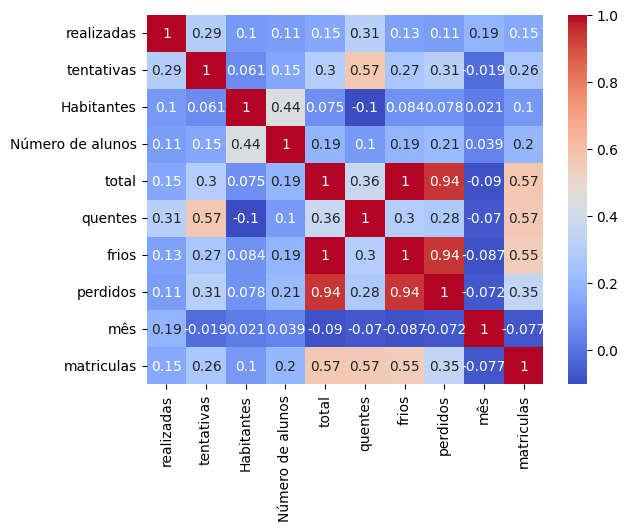

In [29]:
matriz_corr = df.drop(columns = ['updated_month', 'escola_id', 'Escolas']).corr()
sns.heatmap(data = matriz_corr, cmap = 'coolwarm', annot = True)

In [30]:
dados_brutos = df

Analisando a matriz de correlação apenas na linha de número de matrículas, todas as nossas informações apresentam correlação significativa. É importante citar que a correlação baixa em mês se refere ao fato de que temos um número muito grande de meses com poucas matrículas, então talvez valeria a pena agrupar por bimestre, por exemplo. Como não é o nosso foco, esperamos que pelo menos um modelo de árvore possa identificar as tendências

Transformando dados

In [31]:
df = df.drop(columns = ['updated_month', 'escola_id', 'Escolas'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   realizadas        194 non-null    float64
 1   tentativas        194 non-null    float64
 2   Habitantes        194 non-null    float64
 3   Número de alunos  194 non-null    float64
 4   total             194 non-null    int64  
 5   quentes           194 non-null    float64
 6   frios             194 non-null    float64
 7   perdidos          194 non-null    float64
 8   mês               194 non-null    float64
 9   matriculas        194 non-null    float64
dtypes: float64(9), int64(1)
memory usage: 15.3 KB


Transformando as colunas em categóricas

In [32]:
df['mês'] = df['mês'].astype('category')

Testando uma regressão linear

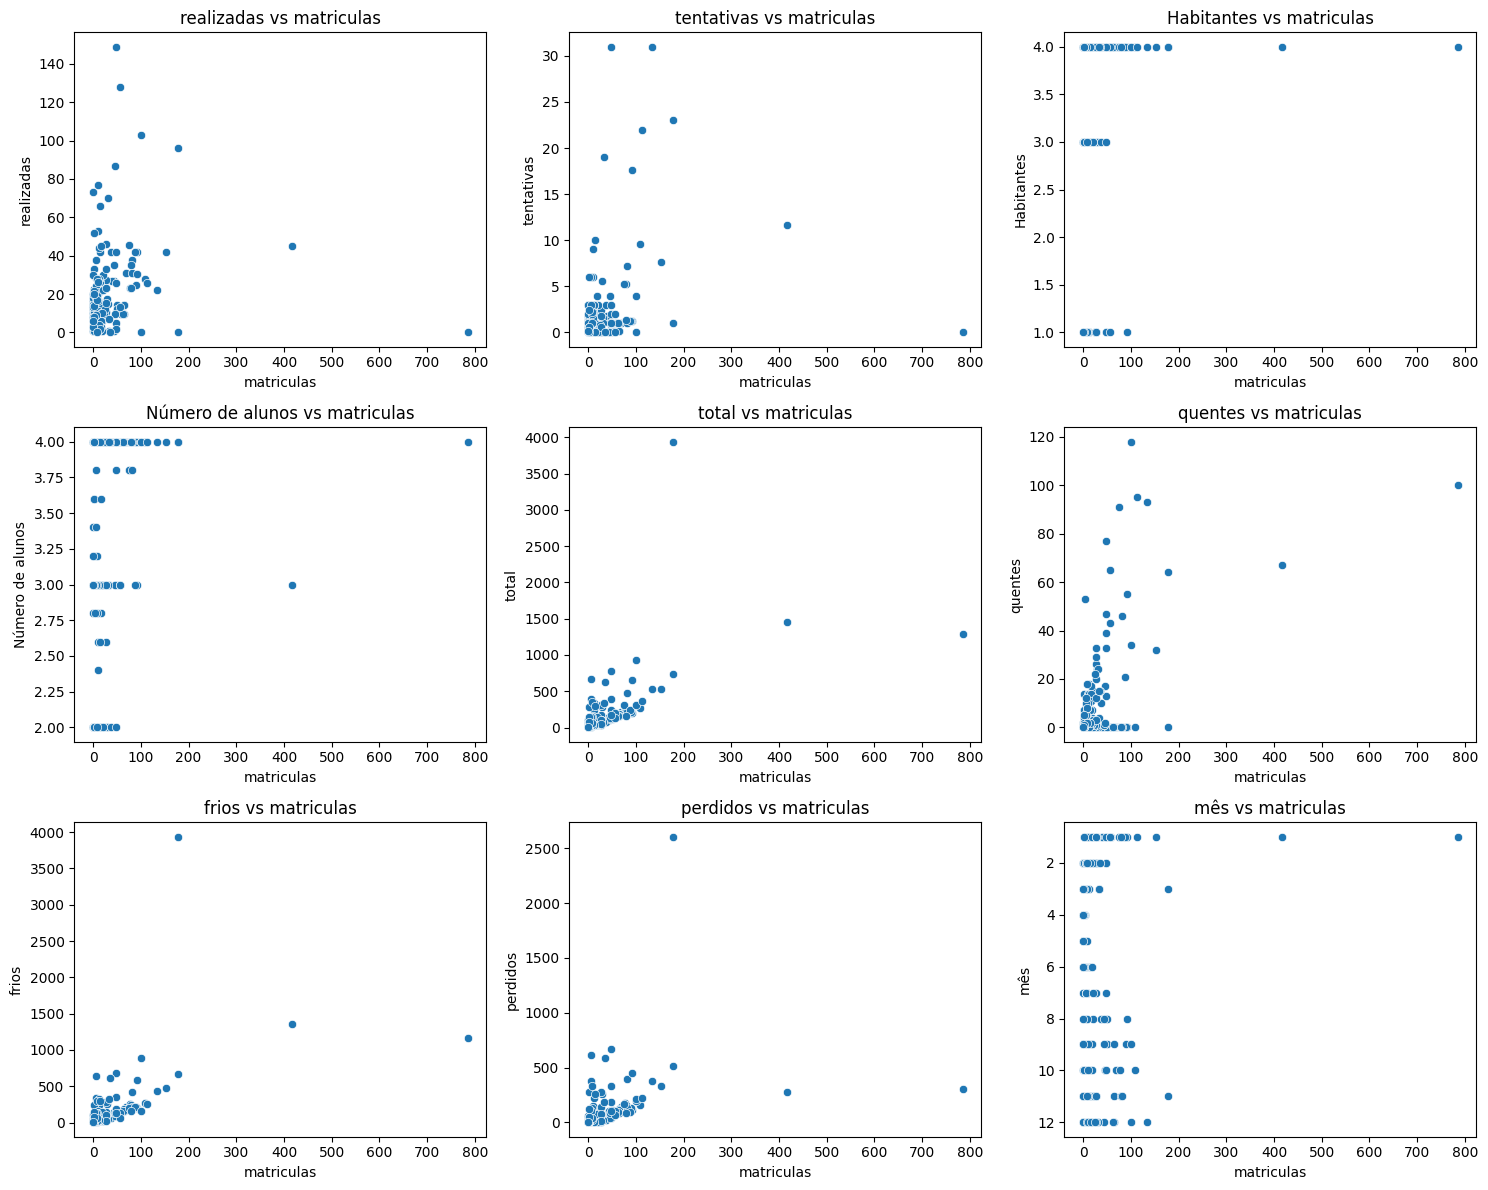

In [33]:
coluna_referencia = 'matriculas'
variaveis = [col for col in df.columns if col != coluna_referencia]

n = len(variaveis)
cols = 3
rows = (n + cols - 1) // cols

plt.figure(figsize=(5 * cols, 4 * rows))

for i, col in enumerate(variaveis):
    plt.subplot(rows, cols, i + 1)
    sns.scatterplot(data=df, x=coluna_referencia, y=col)
    plt.title(f'{col} vs {coluna_referencia}')

plt.tight_layout()
plt.show()

Vamos manter os outliers do jeito que estão, apesar de ser relativamente errado fazer isso, mas não temos muitos dados


Para transformar os dados, vamos usar one-hot encoding para categóricas, entretanto, como temos 12 meses, a matriz vai ficar bem esparsa;

O ideal aqui é ter uma variável índice do mês:

Ex: (Aqui vale o guru)

Mês quente: Nov, Dez, Jan -> indice = 2
Mês morno: Jul, Jun (não sei bem) -> indice = 1
Mês frio: índice = 0

E isso aqui a série temporal seria bizu:
- O modelo de série iria cuspir a trend, sazon e ruído do mês, e isso seria transformado nesse índice;
- Desse jeito seria mais preciso, a gente ia poder considerar o crescimento do colégio, período, melhor do que uma análise mais simples que nem eu propus em cima. Enquanto isso não chega, vou manter o de cima

Vamos testar os dois casos(deixando a matriz esparsa e outra abordagem com os índices)

Dividindo em explicativas e alvo

In [34]:
def classificar_mes(mes):
    if mes in [10, 11, 12, 1]:
        return 2 # quente
    elif mes in [2, 3, 7, 8, 9]: 
        return 1 # morno
    else:
        return 0 # frio

df['mes_indic'] = df['mês'].apply(classificar_mes)

In [35]:
# explicativas(x)
x = df.drop(columns = ['matriculas'], axis = 1)
# alvo(y)
y = df['matriculas'].copy()

In [36]:
x['mês'] = x['mês'].astype('int64')
colunas_categ = ['mês']

# Cria o transformer
one_hot = make_column_transformer(
    (OneHotEncoder(drop='if_binary', sparse_output=False), colunas_categ),
    remainder='passthrough'
)

x_transf = one_hot.fit_transform(x)

nomes_categ = one_hot.named_transformers_['onehotencoder'].get_feature_names_out(colunas_categ)
colunas_remainder = [col for col in x.columns if col not in colunas_categ]
novos_nomes_colunas = list(nomes_categ) + colunas_remainder

# Cria novo DataFrame com os nomes
x1 = pd.DataFrame(x_transf, columns=novos_nomes_colunas)
x1.drop(columns= 'mes_indic', inplace = True)
x1

,mês_1,mês_2,mês_3,mês_4,mês_5,mês_6,mês_7,mês_8,mês_9,mês_10,mês_11,mês_12,realizadas,tentativas,Habitantes,Número de alunos,total,quentes,frios,perdidos
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.4,0.2,4.0,4.0,2.0,0.0,2.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6.4,0.4,4.0,4.0,6.0,0.0,6.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,16.4,1.0,4.0,4.0,10.0,0.0,10.0,10.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6.4,0.2,4.0,4.0,5.0,0.0,5.0,5.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.4,0.2,4.0,4.0,2.0,0.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,2.0,66.0,2.0,63.0,40.0
190,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,19.0,4.0,4.0,336.0,15.0,320.0,184.0
191,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.6,4.0,4.0,72.0,1.0,69.0,51.0
192,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.2,1.0,3.0,4.0,0.0,3.0,2.0


Normalizando os dados para os modelos - não importa para árvores, mas é importante para modelos lineares

In [37]:
scaler = MinMaxScaler()
x1_scaled = scaler.fit_transform(x1)
x1 = pd.DataFrame(x1_scaled, columns=x1.columns, index=x1.index)
x1

,mês_1,mês_2,mês_3,mês_4,mês_5,mês_6,mês_7,mês_8,mês_9,mês_10,mês_11,mês_12,realizadas,tentativas,Habitantes,Número de alunos,total,quentes,frios,perdidos
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.042953,0.006452,1.000000,1.0,0.000254,0.000000,0.000254,0.000384
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.042953,0.012903,1.000000,1.0,0.001269,0.000000,0.001270,0.001919
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.110067,0.032258,1.000000,1.0,0.002284,0.000000,0.002285,0.003839
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.042953,0.006452,1.000000,1.0,0.001015,0.000000,0.001016,0.001919
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.042953,0.006452,1.000000,1.0,0.000254,0.000000,0.000254,0.000768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.032258,0.666667,0.0,0.016497,0.016949,0.015744,0.015355
190,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046980,0.612903,1.000000,1.0,0.085025,0.127119,0.081006,0.070633
191,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.134228,0.019355,1.000000,1.0,0.018020,0.008475,0.017268,0.019578
192,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040268,0.006452,0.000000,0.5,0.000761,0.000000,0.000508,0.000768


In [38]:
X_train, X_test, y_train, y_test = train_test_split(x1, y, test_size = 0.3, random_state = 7)

In [39]:
import statsmodels.api as sm
X_train = sm.add_constant(X_train)

modelo_1 = sm.OLS(y_train, X_train).fit()
print(modelo_1.summary())

                            OLS Regression Results                            
Dep. Variable:             matriculas   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     23.44
Date:                Mon, 24 Mar 2025   Prob (F-statistic):           6.22e-31
Time:                        13:27:36   Log-Likelihood:                -678.05
No. Observations:                 135   AIC:                             1396.
Df Residuals:                     115   BIC:                             1454.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -6.7039      9.868  

Beleza, nossa métrica que é o R2 tá até legal, mas note que tem valores p's bem maior que 5%, que é um problema;

In [40]:
X_test = sm.add_constant(X_test, has_constant='add')
predict1 = modelo_1.predict(X_test)
predict1

24      22.113259
133     54.037115
113     19.145469
22       8.976128
131     50.950343
192    -11.109198
46      16.986220
143     41.454812
154      6.694720
65       2.269458
148     74.837653
173     27.715463
171     17.801530
98      12.516924
109     10.931312
85       2.968300
114      2.501101
134     27.313216
138     41.502177
74       2.711277
40      -7.706945
155    -11.244017
11      17.589767
150     -5.880424
99       3.080239
80      13.840431
129     18.965001
102     13.651354
94       3.269455
117      4.630096
181      8.147968
2       39.045686
178     61.295768
115     17.468855
27      39.014715
78     -12.434727
31     -11.920029
149     18.038030
32       2.610715
13      13.811794
116     14.887204
106      9.250755
124    -14.976191
57      40.219388
18      19.423460
126    -30.485615
164    119.869606
120     -5.096076
82       2.919220
60      19.604535
86      75.715449
36     -15.990650
45      47.128921
84     -13.957727
101    -22.324017
51      61

In [41]:
from sklearn.metrics import r2_score
print("R²: ", r2_score(y_test, predict1))

R²:  -0.03269318291065826


Ou seja, o modelo é horrível.
Vamos ver a segunda opção:

<Axes: xlabel='mês', ylabel='matriculas'>

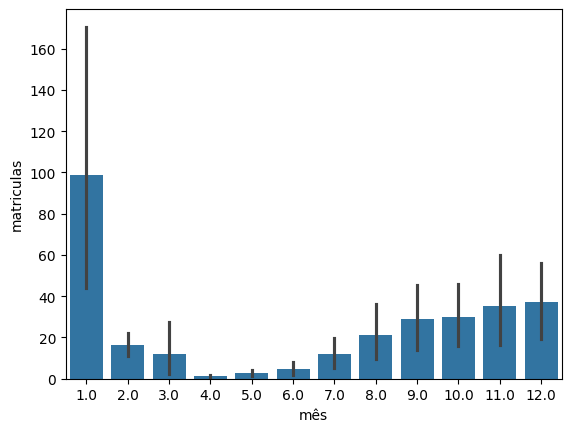

In [42]:
sns.barplot(data = df, x = 'mês', y = 'matriculas')

Isso aqui é o que a série vai dar pra gente

In [43]:
x2 = x
scaler = MinMaxScaler()
x2_scaled = scaler.fit_transform(x2)
x2 = pd.DataFrame(x2_scaled, columns=x2.columns, index=x2.index)
x2

,realizadas,tentativas,Habitantes,Número de alunos,total,quentes,frios,perdidos,mês,mes_indic
0,0.042953,0.006452,1.000000,1.0,0.000254,0.000000,0.000254,0.000384,0.636364,0.5
1,0.042953,0.012903,1.000000,1.0,0.001269,0.000000,0.001270,0.001919,0.727273,0.5
2,0.110067,0.032258,1.000000,1.0,0.002284,0.000000,0.002285,0.003839,0.818182,1.0
3,0.042953,0.006452,1.000000,1.0,0.001015,0.000000,0.001016,0.001919,0.909091,1.0
4,0.042953,0.006452,1.000000,1.0,0.000254,0.000000,0.000254,0.000768,1.000000,1.0
...,...,...,...,...,...,...,...,...,...,...
189,0.000000,0.032258,0.666667,0.0,0.016497,0.016949,0.015744,0.015355,0.181818,0.5
190,0.046980,0.612903,1.000000,1.0,0.085025,0.127119,0.081006,0.070633,0.181818,0.5
191,0.134228,0.019355,1.000000,1.0,0.018020,0.008475,0.017268,0.019578,0.181818,0.5
192,0.040268,0.006452,0.000000,0.5,0.000761,0.000000,0.000508,0.000768,0.181818,0.5


In [44]:
X_train, X_test, y_train, y_test = train_test_split(x2, y, test_size = 0.3, random_state = 7)

In [45]:
import statsmodels.api as sm
X_train = sm.add_constant(X_train)

modelo_2 = sm.OLS(y_train, X_train).fit()
print(modelo_2.summary())

                            OLS Regression Results                            
Dep. Variable:             matriculas   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     45.25
Date:                Mon, 24 Mar 2025   Prob (F-statistic):           1.17e-36
Time:                        13:27:36   Log-Likelihood:                -681.22
No. Observations:                 135   AIC:                             1384.
Df Residuals:                     124   BIC:                             1416.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -20.2659     12.403  

In [46]:
X_test = sm.add_constant(X_test, has_constant='add')
predict2 = modelo_2.predict(X_test)
predict2

24      24.461684
133     37.177583
113     18.477146
22       2.786208
131     33.399669
192     -2.366637
46       4.776416
143     29.457735
154     23.107728
65      -1.546443
148     62.608214
173     23.692917
171     14.021945
98       5.932534
109     10.619829
85       0.578925
114      5.257064
134     10.981090
138     29.547706
74      12.865968
40      -8.166686
155      7.011805
11      17.370974
150     10.367343
99       4.149767
80       9.775087
129      6.188345
102     14.415198
94      -5.333594
117     11.610778
181      5.713114
2       23.304057
178     53.875926
115     18.909450
27      28.763630
78     -17.221845
31      -2.479965
149     35.119708
32      12.809711
13      20.458766
116     14.385895
106     10.279815
124     -7.283079
57      41.196615
18      16.782464
126    -16.349441
164    110.942011
120      5.404415
82      -0.544235
60      16.632918
86      68.588729
36     -21.216453
45      33.270076
84     -15.889460
101    -15.877101
51      61

In [47]:
from sklearn.metrics import r2_score
print("R²: ", r2_score(y_test, predict1))

R²:  -0.03269318291065826


Horrível também.
Suponho que seja porque não temos uma variabilidade muito grande dos dados, acho que vale a pena usar LSTM ou KNN para gerar novos similares

Testando um modelo de árvore

In [50]:
x['mês'] = x['mês'].astype('category')
x

,realizadas,tentativas,Habitantes,Número de alunos,total,quentes,frios,perdidos,mês,mes_indic
0,6.4,0.2,4.0,4.0,2,0.0,2.0,1.0,8,1
1,6.4,0.4,4.0,4.0,6,0.0,6.0,5.0,9,1
2,16.4,1.0,4.0,4.0,10,0.0,10.0,10.0,10,2
3,6.4,0.2,4.0,4.0,5,0.0,5.0,5.0,11,2
4,6.4,0.2,4.0,4.0,2,0.0,2.0,2.0,12,2
...,...,...,...,...,...,...,...,...,...,...
189,0.0,1.0,3.0,2.0,66,2.0,63.0,40.0,3,1
190,7.0,19.0,4.0,4.0,336,15.0,320.0,184.0,3,1
191,20.0,0.6,4.0,4.0,72,1.0,69.0,51.0,3,1
192,6.0,0.2,1.0,3.0,4,0.0,3.0,2.0,3,1


In [52]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 7)

In [56]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, root_mean_squared_error

dtreino = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dteste = xgb.DMatrix(X_test, y_test, enable_categorical=True)

params = {'objective': 'reg:squarederror'}

modelo = xgb.train(
    params=params,
    dtrain=dtreino,
    num_boost_round=100
)

preds = modelo.predict(dteste)

rmse = root_mean_squared_error(dteste.get_label(), preds)
print(f'RMSE: {rmse:.2f}')

RMSE: 12.07


Avaliando overfitting

In [58]:
rmse = root_mean_squared_error(dtreino.get_label(), modelo.predict(dtreino))
print(f'RMSE: {rmse:.2f}')

RMSE: 0.00


Deu overfitting! Vamos otimizar os hyperparametros

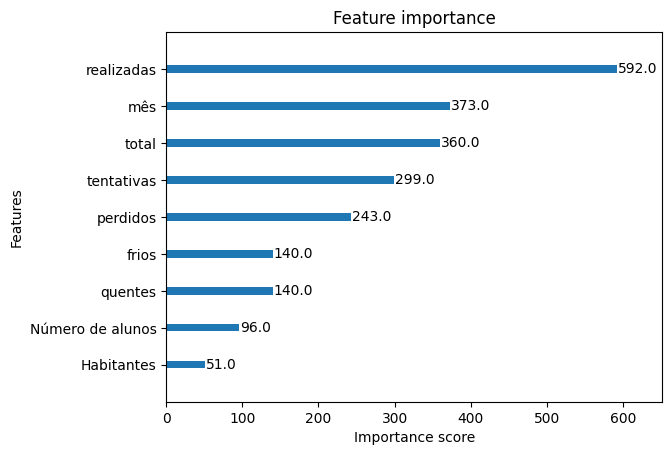

In [57]:
xgb.plot_importance(modelo)
plt.grid(False)
plt.show()

Beleza, ótimo resultado! Entretanto, vamos ver os parâmetros

In [ ]:
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid = {
    # colsample_bytree = número de features
    'colsample_bytree': [0.8, 1],
    # subsample = porcentagem da amostra
    'subsample': [0.5, 0.8, 1],
    'max_depth': [3, 5, 8, 10],
    'n_estimators': [100]
}

gbm = xgb.XGBRegressor(enable_categorical=True)

grid = GridSearchCV(
    estimator = gbm,
    param_grid = param_grid,
    scoring = 'neg_mean_squared_error',
    cv = 5,
    verbose = 1
)

grid.fit(x, y)

print('Melhores hiperparâmetros encontrados: ', grid.best_params_)
print('Menor RMSE encontrado: ', np.sqrt(np.abs(grid.best_score_)))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Melhores hiperparâmetros encontrados:  {'colsample_bytree': 0.8, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}
Menor RMSE encontrado:  50.55675481098369


In [60]:
params = {'colsample_bytree': 0.8, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1, 'learning_rate': 0.01}

modelo_final = xgb.train(
    params=params,
    dtrain=dtreino
)

preds = modelo_final.predict(dteste)
rmse = root_mean_squared_error(dteste.get_label(), preds)
print(f'RMSE: {rmse:.2f}')

RMSE: 27.44


C:\Users\fealp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [13:49:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [62]:
rmse = root_mean_squared_error(dtreino.get_label(), modelo_final.predict(dtreino))
print(f'RMSE: {rmse:.2f}')

RMSE: 76.31


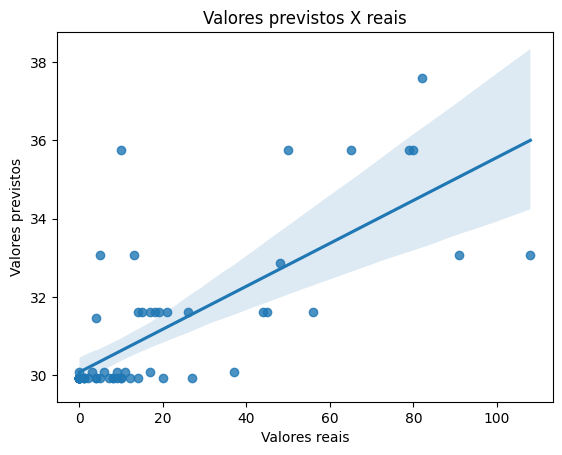

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.regplot(x=y_test, y=preds)
plt.xlabel('Valores reais')
plt.ylabel('Valores previstos')
plt.title('Valores previstos X reais')
plt.show()

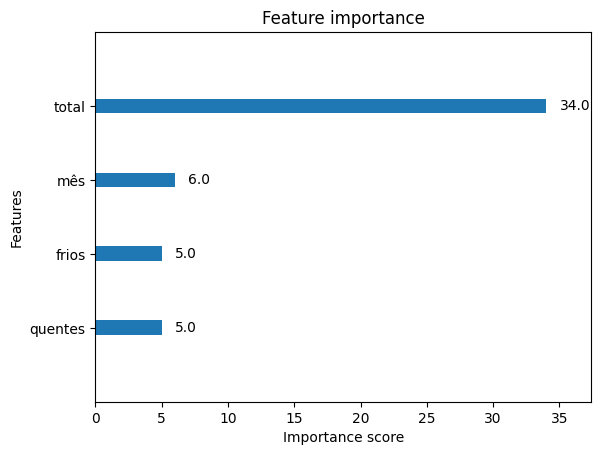

In [64]:
xgb.plot_importance(modelo_final)
plt.grid(False)
plt.show()